# Practical Session 4 - Deep Learning with PyTorch
In this session we will start with our toy task again.
Remember how we solved it with an MLP in the first class ?
We used scikit-learn, a one liner but without control over what was happening.

We will start by implementing the model in Pytorch, in a basic way.

Then we will work our way to making our code looks like a real Pytorch code.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time

np.random.seed(20)


def base_function(x):
    y = 1.3 * x ** 3 - 3 * x ** 2 + 3.6 * x + 6.9
    return y


sample_input = torch.ones(size=(6, 28, 28))
reshaped = torch.reshape(sample_input, (sample_input.shape[0], 784))
print(reshaped.shape)

torch.Size([6, 784])


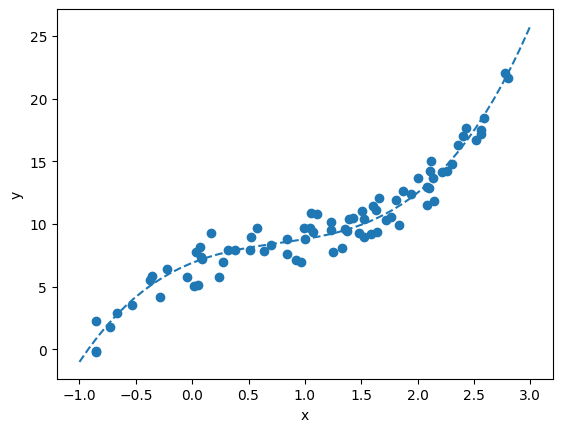

In [3]:
low, high = -1, 3
n_points = 80

# Get the values
xs = np.random.uniform(low, high, n_points)
sample_ys = base_function(xs)
ys_noise = np.random.normal(size=len(xs))
noisy_sample_ys = sample_ys + ys_noise

# Plot the hidden function
lsp = np.linspace(low, high)
true_ys = base_function(lsp)
plt.plot(lsp, true_ys, linestyle='dashed')

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We used the following command to fit the regressor last time :
"from sklearn.neural_network import MLPRegressor
 mlp_model = MLPRegressor(max_iter=5000)"

By default, the MLP Regressor makes the following computational graph :
- input gets multiplied by a matrix with 100 parameters, and an additional parameter is added to each values, giving 100 outputs y (shape = (n_samples, 100))
- ReLU is applied to each of these outputs (shape = (n_samples, 100)). The relu function is implemented in PyTorch with torch.nn.functional.relu(x)
- Then this value is multiplied by a matrix to produce a scalar output (again 100 parameters) (shape = (n_samples, 1)) and shifted by an offset.

A quick reminder on matrix multiplication : it is an operation that combines one matrix A of shape (m,n) and a matrix B of shape (n,p) into a matrix C of shape (m,p). In PyTorch (and NumPy), you need to call torch.matmul(A,B) to make this computation.

To make the two big multiplications, we will use one torch tensor of 100 parameters for each multiplication, with the appropriate shape.Create random starting tensors of parameters.

Then implement the asked computation to produce our output from our input. You should debug the operations by ensuring the shapes are correct.


In [4]:
# First create the parameters with small random initial values.
# We need to mention that we want to compute a gradient
# I provide you with the example for the first one :
w1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True)
b1 = torch.normal(mean=0., std=0.1, size=(1, 100), requires_grad=True)
w2 = torch.normal(mean=0., std=0.1, size=(100, 1), requires_grad=True)
b2 = torch.normal(mean=0., std=0.1, size=(1,), requires_grad=True)

In [5]:
# Then define the function
def f(x, weight1=w1, bias1=b1, weight2=w2, bias2=b2):
    y1 = torch.matmul(x, weight1) + bias1
    a1 = torch.nn.functional.relu(y1)
    out = torch.matmul(a1, weight2) + bias2
    return out


# Just to be sure everything runs, we make an inference on an example input of 6 random values
sample_input = torch.ones(size=(6, 1))
f(sample_input).shape

torch.Size([6, 1])

Now we will mostly use last class optimization procedure to train our network using Pytorch



In [5]:
# Also set up the data
# Check that when doing inference on the data, we get an output tensor of shape (80,1).
# Call us if it is not the case, there is something ~ subtle and not interesting
torch_xs = torch.from_numpy(xs).float()[:, None]
torch_noisy_ys = torch.from_numpy(noisy_sample_ys)[:, None]
f(torch_xs).shape

torch.Size([80, 1])

In [6]:
# Now like last time, let us define an optimizer and give the parameters to it.
n_iter = 2000
opt = torch.optim.Adam([w1, b1, w2, b2], lr=0.01)

In [7]:
# Loop over the data, make the forward, backward, step and zero grad
for i in range(n_iter):
    prediction = f(torch_xs, w1, b1, w2, b2)
    loss = torch.mean((prediction - torch_noisy_ys) ** 2)
    loss.backward()
    opt.step()
    opt.zero_grad()
    if not i % 10:
        print(i, loss.item())

0 116.73420933671314
10 107.61666385198626
20 87.61322488435134
30 48.8924144074449
40 3.7156777082034864
50 5.9852604415284025
60 3.6201239313138247
70 3.0894695732962516
80 2.9000194303468128
90 2.8699861478993585
100 2.8151391517487694
110 2.7842442769459868
120 2.758980614512756
130 2.739061146884314
140 2.7211683098299098
150 2.704812247017221
160 2.688937715569291
170 2.673303055008295
180 2.6578724912023524
190 2.642554900324115
200 2.628130476733226
210 2.6144775657164865
220 2.5997340310845587
230 2.5840513535820095
240 2.5670763379400223
250 2.5479417911544884
260 2.525721750000703
270 2.499334663948614
280 2.468555230556496
290 2.4322596994854324
300 2.3893979826860323
310 2.339992249732325
320 2.2839187325369625
330 2.2222707642137345
340 2.156429770148
350 2.088241965084132
360 2.021982196986866
370 1.960880456315591
380 1.9076642270046207
390 1.8630148626302963
400 1.8274951674797713
410 1.798176003239232
420 1.77295653559417
430 1.7499133104339002
440 1.7289608562094425


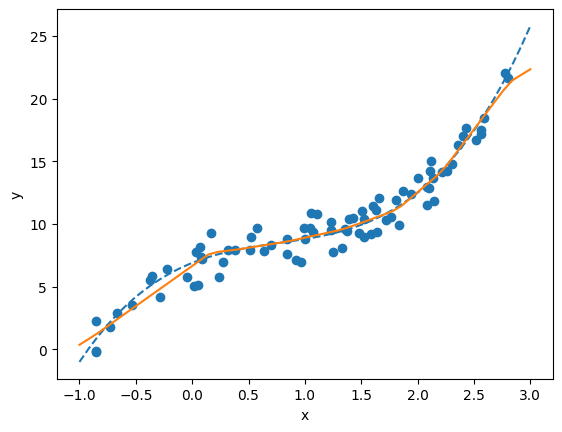

In [8]:
torch_lsp = torch.from_numpy(lsp).float()[:, None]
predicted_ys = f(torch_lsp).detach().numpy()

plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Congratulations, you have coded yourself a MLP model ! We have used the computation graph framework.


Now let us make our code prettier (more Pytorch) and more efficient.
First let us refactor the model in the proper way it should be coded, by using the torch.nn.Module class.
You should add almost no new code, just reorganize the one above into a class.

In [9]:
from torch.nn import Module, Parameter


class MyOwnMLP(Module):
    def __init__(self):
        super(MyOwnMLP, self).__init__()
        self.w1 = Parameter(torch.normal(mean=0., std=0.1, size=(1, 100)))
        self.b1 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))
        self.w2 = Parameter(torch.normal(mean=0., std=0.1, size=(100, 1)))
        self.b2 = Parameter(torch.normal(mean=0., std=0.1, size=(1,)))

    def forward(self, x):
        y1 = torch.matmul(x, self.w1) + self.b1
        a1 = torch.nn.functional.relu(y1)
        out = torch.matmul(a1, self.w2) + self.b2
        return out


model = MyOwnMLP()
out = model(torch_xs)
out.shape

torch.Size([80, 1])

Now we are good to also make the data iteration process look like Pytorch code !

We need to define a Dataset object. Once we have this, we can use it to create a DataLoader object

In [10]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        x = self.data_x[idx]
        y = self.data_y[idx]
        return x, y

In [11]:
# Loop and wait for each data point in PyTorch
dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)
start = time.time()
for point in dataloader:
    pass
print('Done in pytorch : ', time.time() - start)

Done in pytorch :  0.12343168258666992


The last thing missing to make our pipeline truly Pytorch is to use a GPU.

In Pytorch it is really easy, you just need to 'move' your tensors to a 'device'.
You can test if a gpu is available and create the appropriate device with the following lines:

In [12]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'
torch_xs = torch_xs.to(device)

Now we finally have all the elements to make an actual Pytorch complete pipeline !

Create a model, and try to put it on a device.
Create an optimizer with your model's parameters
Make your data into a dataloader

Then use two nested for loops : one for 100 epochs, and in each epoch loop over the dataloader
    Inside the loop, for every batch first put the data on the device
    Then use the semantics of above :
        - model(batch)
        - loss computation and backward
        - gradient step and zero_grad

In [13]:
n_epochs = 200
model = MyOwnMLP()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

dataset = CustomDataset(data_x=torch_xs, data_y=torch_noisy_ys)
dataloader = DataLoader(dataset=dataset, batch_size=10, num_workers=6)

loss = 0
for epoch in range(n_epochs):
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        prediction = model(batch_x)
        loss = torch.mean((prediction - batch_y) ** 2)
        loss.backward()
        opt.step()
        opt.zero_grad()
        loss = loss.item()
    if not epoch % 10:
        print(epoch, loss)

# To easily use the trained model we need to send it back to cpu at the end
model = model.to('cpu')

0 141.09646508612568
10 5.020805486489667
20 4.580017410134488
30 4.372838885927111
40 4.201923989106854
50 4.03404025332816
60 3.87580548620853
70 3.6803988303338797
80 3.461580774924279
90 3.2990358157066124
100 3.121203834594307
110 2.918246069981979
120 2.788983478365348
130 2.6452860699513887
140 2.533261340986804
150 2.4204639718739824
160 2.350778580526362
170 2.272824814949589
180 2.187296423047029
190 2.122884542968142


We finally can plot the last model

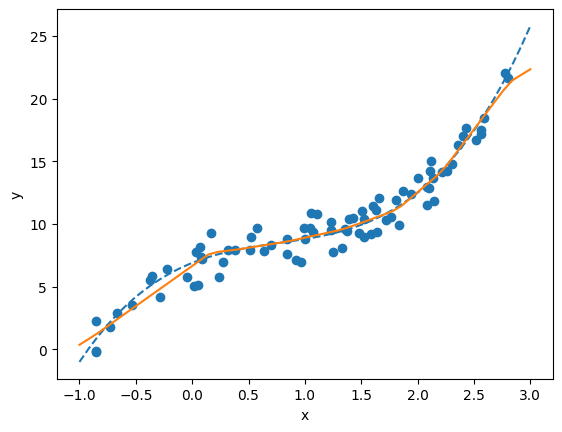

In [14]:
plt.plot(lsp, true_ys, linestyle='dashed')
plt.plot(lsp, predicted_ys)

# Plot the samples
plt.scatter(xs, noisy_sample_ys)
plt.xlabel('x')
plt.ylabel('y')
plt.show()